In [1]:
!pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 8.6 MB/s eta 0:00:00



--- Analisando: Controlador Lag (Precisão) ---
[Nominal (Ideal)] Overshoot Máximo: 12.86%
[Pesado (Motor Fraco/Atrito Alto)] Overshoot Máximo: 2.84%
[Agressivo (Motor Forte/Sem Atrito)] Overshoot Máximo: 29.51%


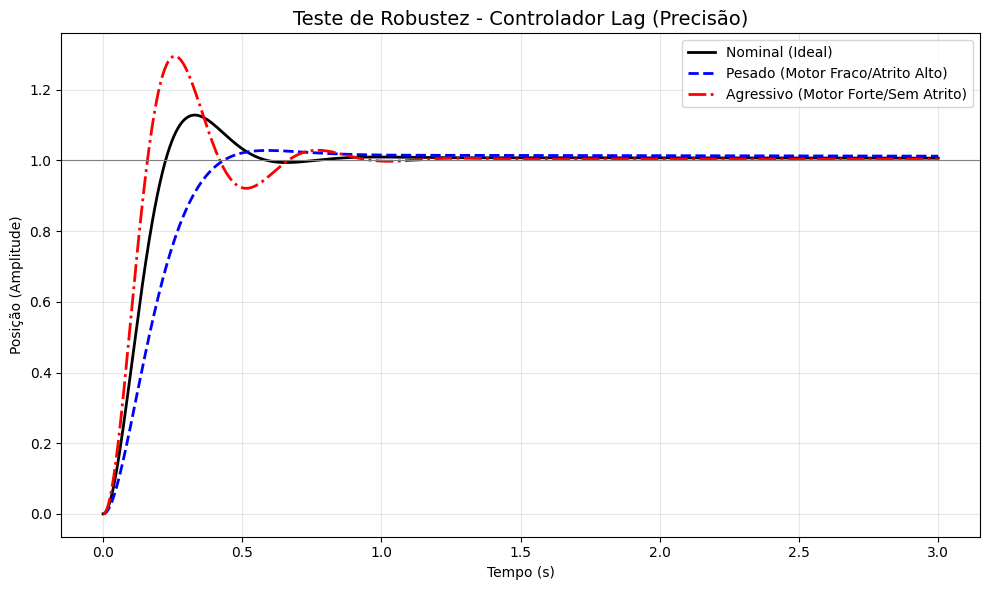


--- Analisando: Controlador Lead (Velocidade) ---
[Nominal (Ideal)] Overshoot Máximo: 1.24%
[Pesado (Motor Fraco/Atrito Alto)] Overshoot Máximo: -0.00%
[Agressivo (Motor Forte/Sem Atrito)] Overshoot Máximo: 8.75%


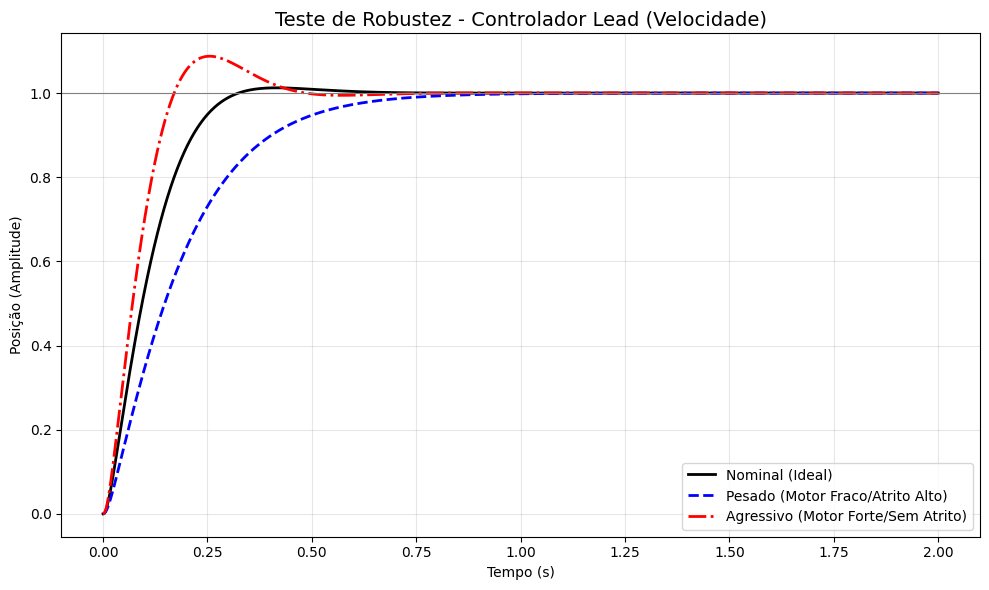

In [2]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt

# --- 1. FUNÇÃO PARA CRIAR A PLANTA (MOTOR) ---
def criar_planta(Km, am, ae):
    K_sys = 772  # Constante do sistema fixa
    num = [Km * K_sys]
    # Denominador: s(s+am)(s+ae) -> s^3 + (am+ae)s^2 + (am*ae)s
    den = [1, (am + ae), (am * ae), 0]
    return ct.tf(num, den)

# --- 2. DEFINIÇÃO DOS CENÁRIOS DE ESTRESSE (ROBUSTEZ) ---
cenarios = {
    "Nominal (Ideal)":
        {"Km": 1.1, "am": 13.2, "ae": 950, "cor": 'black', "estilo": '-'},

    "Pesado (Motor Fraco/Atrito Alto)":
        {"Km": 0.8, "am": 15.0, "ae": 1100, "cor": 'blue', "estilo": '--'},

    "Agressivo (Motor Forte/Sem Atrito)":
        {"Km": 1.2, "am": 10.0, "ae": 800,  "cor": 'red', "estilo": '-.'}
}

# --- 3. DEFINIÇÃO DOS CONTROLADORES FINAIS  ---

# Compensador LAG
# K=150.6, z=0.1, p=0.01
C_Lag = 150.6 * ct.tf([1, 0.1], [1, 0.01])

# Compensador LEAD
# K=700, z=20, p=100
C_Lead = 700 * ct.tf([1, 20], [1, 100])

controladores = {"Lag (Precisão)": C_Lag, "Lead (Velocidade)": C_Lead}

# --- 4. LOOP DE SIMULAÇÃO E PLOTAGEM ---
for nome_ctrl, ctrl in controladores.items():
    plt.figure(figsize=(10, 6))

    print(f"\n--- Analisando: Controlador {nome_ctrl} ---")

    for nome_cenario, params in cenarios.items():
        # A. Cria a planta específica deste cenário
        Planta = criar_planta(params["Km"], params["am"], params["ae"])

        # B. Fecha a malha de controle
        # T = (C*G) / (1 + C*G)
        Sistema_Fechado = ct.feedback(ctrl * Planta, 1)

        # C. Simula a resposta ao degrau
        # Ajustamos o tempo (T) dependendo se é Lead (rápido) ou Lag (lento)
        tempo_sim = 2.0 if "Lead" in nome_ctrl else 3.0
        t, y = ct.step_response(Sistema_Fechado, T=np.linspace(0, tempo_sim, 1000))

        # D. Plota a curva
        plt.plot(t, y, color=params["cor"], linestyle=params["estilo"],
                 linewidth=2, label=nome_cenario)

        # E. Calcula o Overshoot para exibir no texto
        mp = (np.max(y) - 1) * 100
        print(f"[{nome_cenario}] Overshoot Máximo: {mp:.2f}%")

    # Configuração visual do gráfico
    plt.title(f'Teste de Robustez - Controlador {nome_ctrl}', fontsize=14)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Posição (Amplitude)')
    plt.axhline(1.0, color='gray', linewidth=0.8) # Linha de referência
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()